<a href="https://colab.research.google.com/github/wander-design/ai_train_mfti2024/blob/main/73%22olimpiad_ai_vk_images_baseline_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений

Базовый ноутбук для решения задания [Всероссийской олимпиады по искусственному интеллекту](https://ai.edu.gov.ru/) "Классификация изображений".

**Направление**: компьютерное зрение.

Для изменения нужно скопировать ноутбук. Файл -> Сохранить копию на диске...

Не забудьте включть GPU: Среда выполнения -> Сменить среду выполнения -> T4 GPU

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем набор данных

In [ ]:
!wget -O train.zip https://www.dropbox.com/scl/fi/2418ow22jrtt5200db5f0/preprocessed_train.zip?rlkey=wvwdozyl1e1h69kxfvtqk4xri&dl=1

--2024-07-11 13:42:43--  https://www.dropbox.com/scl/fi/2418ow22jrtt5200db5f0/preprocessed_train.zip?rlkey=wvwdozyl1e1h69kxfvtqk4xri
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca2efb670b675c492dfde731eff.dl.dropboxusercontent.com/cd/0/inline/CWjQIhHuwpwX-AbK1CxwOx3POnZSRyZevhXqU873UlvfoXu1wqOS_C3KEgElcmq3P2uuwzafCl_j2_X3kXLrqvcfpmKNOqSpiNVSMZnKKyXjMZaUDQgEXTy3korRv43Kc-M/file# [following]
--2024-07-11 13:42:44--  https://uca2efb670b675c492dfde731eff.dl.dropboxusercontent.com/cd/0/inline/CWjQIhHuwpwX-AbK1CxwOx3POnZSRyZevhXqU873UlvfoXu1wqOS_C3KEgElcmq3P2uuwzafCl_j2_X3kXLrqvcfpmKNOqSpiNVSMZnKKyXjMZaUDQgEXTy3korRv43Kc-M/file
Resolving uca2efb670b675c492dfde731eff.dl.dropboxusercontent.com (uca2efb670b675c492dfde731eff.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6019:15::a27d:40f
Connecting 

In [ ]:
!unzip train.zip

Archive:  train.zip
   creating: preprocessed_train/ads/
  inflating: preprocessed_train/ads/849433210092.jpg  
  inflating: preprocessed_train/ads/861945621054.jpg  
  inflating: preprocessed_train/ads/865768123444.jpg  
  inflating: preprocessed_train/ads/870095804734.jpg  
  inflating: preprocessed_train/ads/870352278842.jpg  
  inflating: preprocessed_train/ads/873327897052.jpg  
  inflating: preprocessed_train/ads/880375832999.jpg  
  inflating: preprocessed_train/ads/882380261462.jpg  
  inflating: preprocessed_train/ads/882923669493.jpg  
  inflating: preprocessed_train/ads/882923741685.jpg  
  inflating: preprocessed_train/ads/884946095656.jpg  
  inflating: preprocessed_train/ads/886971331682.jpg  
  inflating: preprocessed_train/ads/889536700785.jpg  
  inflating: preprocessed_train/ads/890605388698.jpg  
  inflating: preprocessed_train/ads/891584198605.jpg  
  inflating: preprocessed_train/ads/892040162940.jpg  
  inflating: preprocessed_train/ads/892094330115.jpg  
  inflat

Определяем инструмент предварительной обработки изображений из набора данных

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Загружаем набор данных

In [ ]:
data = datasets.ImageFolder("preprocessed_train", transform=transform)

**Делим набор данных на данные для обучения и проверки**

In [ ]:
# train - набор данных для обучения, 90%
# val - проверочный набор данных, 10%
train, val = random_split(data, [0.7, 0.3])

Количество изображений в наборе данных для обучения

In [ ]:
len(train)

3463

Количество изображений в проверочном наборе данных

In [ ]:
len(val)

1484

Создаем загрузчики данных

In [ ]:
# Размер мини-выборки
batch_size = 64

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Названия классов

In [ ]:
data.class_to_idx

{'ads': 0,
 'animals': 1,
 'cooking': 2,
 'design': 3,
 'entertainment': 4,
 'mass_media': 5,
 'philosophy': 6,
 'travels': 7}

In [ ]:
classes = ['ads', 'animals', 'cooking', 'design', 'entertainment',
           'mass_media', 'philosophy', 'travels']

**Просматриваем примеры изображений**



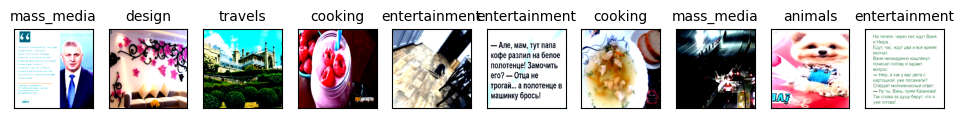

In [ ]:
nsamples=10

imgs, labels = next(iter(trainloader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Создаем модель




In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
device

'cuda'

## Предварительно обученная модель

In [ ]:
resnet = torchvision.models.resnet101(weights='DEFAULT')
#resnet = torchvision.models.efficientnet_b1(weights='DEFAULT')

In [ ]:
for params in resnet.parameters():
    params.requires_grad = False

In [ ]:
#resnet.classifier = nn.Sequential(
resnet.fc = nn.Sequential(
                         nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(1024, 8))

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model = resnet.to(device)
#print(model)

## Обучаем модель

Задаем функцию ошибки - перекрестная энтропия



In [ ]:
loss_fn = nn.CrossEntropyLoss()

Задаем оптимизатор

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Определяем функцию для обучения нейронной сети



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Включаем режим обучения
    model.train()
    # В цикле получаем все мини-выборки
    # X - изображение
    # y - номер класса
    for batch, (X, y) in enumerate(dataloader):
        # Передаем данные на устройство
        X, y = X.to(device), y.to(device)
        # Обнуляем значения градиента
        optimizer.zero_grad()

        # Расчитываем данные на выходе из нейронной сети
        pred = model(X)

        # Расчитываем значение ошибки
        loss = loss_fn(pred, y)

        # Обратное распространение ошиби
        loss.backward()

        # Выполняем шаг обучения (изменение весов)
        optimizer.step()

        # Печатаем прогресс каждые 50 мини-выборок
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Ошибка: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Определяем функцию для проверки качества работы нейронной сети на тестовом наборе данных

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Включаем режим оценки качества модели
    model.eval()
    # Начальные значения
    test_loss, correct = 0, 0
    # Для оценки качества работы не нужно рассчитывать градиент
    with torch.no_grad():
        # В цикле проходим по мини-выборкам из тестового набора данных
        for X, y in dataloader:
            # Передаем данные на устройство
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Качество на проверочном наборе данных: \n Доля правильных ответов: {(100*correct):>0.1f}%, средняя ошибка: {test_loss:>8f} \n")

Обучаем модель в течение 5 эпох



In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    # Обучение модели
    train(trainloader, model, loss_fn, optimizer)
    # Оценка качества работы на проверочном наборе данных
    test(valloader, model, loss_fn)
print("Обучение завершено!")

Эпоха 1
-------------------------------
Ошибка: 2.109704  [   64/ 3463]
Ошибка: 0.872320  [ 3264/ 3463]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 73.0%, средняя ошибка: 0.827461 

Эпоха 2
-------------------------------
Ошибка: 0.970161  [   64/ 3463]
Ошибка: 1.009245  [ 3264/ 3463]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 73.9%, средняя ошибка: 0.807993 

Эпоха 3
-------------------------------
Ошибка: 0.726822  [   64/ 3463]
Ошибка: 0.688034  [ 3264/ 3463]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 74.7%, средняя ошибка: 0.762627 

Эпоха 4
-------------------------------
Ошибка: 0.468543  [   64/ 3463]
Ошибка: 0.622090  [ 3264/ 3463]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 73.3%, средняя ошибка: 0.781036 

Эпоха 5
-------------------------------
Ошибка: 0.317332  [   64/ 3463]
Ошибка: 0.367962  [ 3264/ 3463]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 73.7%, средняя

In [ ]:
test(trainloader, model, loss_fn)

Качество на проверочном наборе данных: 
 Доля правильных ответов: 94.0%, средняя ошибка: 0.236733 



## Распознавание тестового набора данных

### Загрузка тестового набора данных

In [ ]:
!wget -O test.zip https://www.dropbox.com/scl/fi/y7tnbaxrh492pqm7wygzy/test.zip?rlkey=yzcgfp8zrv5bimm1mm08acljt&dl=0

--2024-07-11 13:53:45--  https://www.dropbox.com/scl/fi/y7tnbaxrh492pqm7wygzy/test.zip?rlkey=yzcgfp8zrv5bimm1mm08acljt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d7bb545d1cf93569705ad0446.dl.dropboxusercontent.com/cd/0/inline/CWhXwTP7P32xJaHKwDnxG8JYakjCrD3yXIZD3CB99BhjdbbW57FeoIzXuUnyA9h_gMBw3pRyiH9eTfQyhokXPk0CoaERueZFbAkALSb6ub3jabaBdHwKeSvLgrRiZ8oPezc/file# [following]
--2024-07-11 13:53:45--  https://uc8d7bb545d1cf93569705ad0446.dl.dropboxusercontent.com/cd/0/inline/CWhXwTP7P32xJaHKwDnxG8JYakjCrD3yXIZD3CB99BhjdbbW57FeoIzXuUnyA9h_gMBw3pRyiH9eTfQyhokXPk0CoaERueZFbAkALSb6ub3jabaBdHwKeSvLgrRiZ8oPezc/file
Resolving uc8d7bb545d1cf93569705ad0446.dl.dropboxusercontent.com (uc8d7bb545d1cf93569705ad0446.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uc8d7bb545d

In [ ]:
!unzip test.zip

Archive:  test.zip
replace test/909340245742? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Dataset и DataLoader

Создадим свой класс для загрузки данных из папки

Наследуем от `Dataset`

Особенности написанного класса

* считываются все изображения в папке `img_dir` по индексам, обозначенным в файле `txt_path` (`samples`)
* из файла `txt_path` также берутся метки классов (`target`)

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, txt_path='/content/submission.csv', img_dir='/content/test',
                 transform=None, test=False):
        # df = pd.read_csv(txt_path, sep=';', index_col=0)
        df = pd.read_csv(txt_path, sep=';')
        self.img_names = df['id'].values
        self.df = df
        self.txt_path = txt_path
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def get_image_from_folder(self, name):
        # image = Image.open(os.path.join(self.img_dir, str(name)))
        image = Image.open(os.path.join(self.img_dir, str(name))).convert('RGB')
        return image

    def __getitem__(self, idx):
        sample = self.get_image_from_folder(self.img_names[idx])
        if self.transform is not None:
            sample = self.transform(sample)
        target = 0
        return sample, target

Скачиваем шаблон файла для отправки решения

In [ ]:
!wget -O submission.csv https://www.dropbox.com/scl/fi/ks1097msvjg0hzcpv7f7i/submission.csv?rlkey=xj4xd2tok1tucuetfysb442rg&dl=1

--2024-07-11 13:54:19--  https://www.dropbox.com/scl/fi/ks1097msvjg0hzcpv7f7i/submission.csv?rlkey=xj4xd2tok1tucuetfysb442rg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe95307b798bc44349cafd242d.dl.dropboxusercontent.com/cd/0/inline/CWgPJzboG2f4GFdctS9RqCGH3thyn1jXampRXAANZu5_kKDA7rwD0ZRGiGiePbBPVZyZMX7UCfDx4Bn4cM5UPg4-NAeKqogKfeQinz_HiNpQ23D07geFc2mdWDT48iH5iBM/file# [following]
--2024-07-11 13:54:20--  https://ucbe95307b798bc44349cafd242d.dl.dropboxusercontent.com/cd/0/inline/CWgPJzboG2f4GFdctS9RqCGH3thyn1jXampRXAANZu5_kKDA7rwD0ZRGiGiePbBPVZyZMX7UCfDx4Bn4cM5UPg4-NAeKqogKfeQinz_HiNpQ23D07geFc2mdWDT48iH5iBM/file
Resolving ucbe95307b798bc44349cafd242d.dl.dropboxusercontent.com (ucbe95307b798bc44349cafd242d.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6057:15::a27d:d0f
Connecting to ucbe9

In [ ]:
!head submission.csv

id;label
909340245742;Развлечения и юмор
909342962411;Развлечения и юмор
909343087161;Развлечения и юмор
909344193109;Развлечения и юмор
909346841420;Развлечения и юмор
909353337715;Развлечения и юмор
909353783353;Развлечения и юмор
909354605840;Развлечения и юмор
909356195897;Развлечения и юмор


In [ ]:
submission = pd.read_csv('submission.csv', sep=';', index_col=0)
submission

,label
id,
909340245742,Развлечения и юмор
909342962411,Развлечения и юмор
909343087161,Развлечения и юмор
909344193109,Развлечения и юмор
909346841420,Развлечения и юмор
...,...
970656513024,Развлечения и юмор
970691145216,Развлечения и юмор
970699981568,Развлечения и юмор


Создаем DataSet

In [ ]:
test_dataset = CustomDataSet(txt_path='/content/submission.csv',
                             img_dir='/content/test',
                             transform=transform)

Создаем загрузчик данных.
Важно - данные в этом случае не надо перемешивать, поскольку при загрузке файла с ответом необходим строгий порядок.

In [ ]:
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=1,
                          )

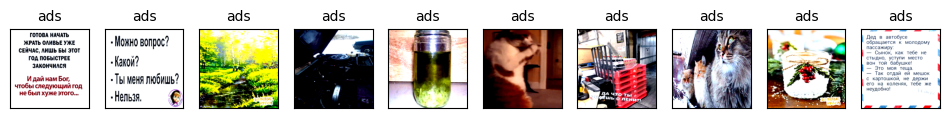

In [ ]:
nsamples=10

imgs, labels = next(iter(test_loader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Реализуем предсказание модели на тестовых данных

In [ ]:
test_predictions = []

for inputs, _ in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds.argmax(dim = 1).data.cpu().numpy())

test_predictions = np.concatenate(test_predictions)


100%|██████████| 81/81 [00:19<00:00,  4.09it/s]


In [ ]:
test_predictions[:100]

array([4, 4, 3, 0, 2, 1, 0, 1, 2, 4, 4, 0, 1, 0, 4, 4, 6, 2, 4, 0, 3, 1,
       0, 0, 7, 3, 4, 4, 4, 4, 0, 4, 3, 4, 1, 0, 0, 2, 5, 5, 0, 6, 1, 2,
       3, 4, 7, 0, 0, 5, 4, 6, 7, 0, 0, 6, 3, 6, 7, 4, 0, 0, 2, 2, 7, 4,
       0, 4, 0, 4, 7, 0, 7, 7, 4, 5, 0, 0, 2, 3, 6, 6, 3, 1, 0, 7, 2, 2,
       4, 0, 2, 2, 7, 0, 7, 0, 4, 4, 1, 4])

Откроем файл для загрузки (предсказания заполнены "Развлечения и юмор")

In [ ]:
submission

,label
id,
909340245742,Развлечения и юмор
909342962411,Развлечения и юмор
909343087161,Развлечения и юмор
909344193109,Развлечения и юмор
909346841420,Развлечения и юмор
...,...
970656513024,Развлечения и юмор
970691145216,Развлечения и юмор
970699981568,Развлечения и юмор


Поместим в файл предсказания модели

In [ ]:
submission.label = test_predictions
submission

,label
id,
909340245742,4
909342962411,4
909343087161,7
909344193109,0
909346841420,0
...,...
970656513024,5
970691145216,3
970699981568,7


Заменяем номера классов на их названия

In [ ]:
class_names = {
    0: 'Торговля и объявления',
    1: 'Животные',
    2: 'Кулинария',
    3: 'Творчество и дизайн',
    4: 'Развлечения и юмор',
    5: 'СМИ',
    6: 'Философия и религия',
    7: 'Путешествия'
}

In [ ]:
submission.replace({'label': class_names}, inplace=True)

In [ ]:
submission

,label
id,
909340245742,Развлечения и юмор
909342962411,Развлечения и юмор
909343087161,Путешествия
909344193109,Торговля и объявления
909346841420,Торговля и объявления
...,...
970656513024,СМИ
970691145216,Творчество и дизайн
970699981568,Путешествия


## Готовим итоговый файл

In [ ]:
submission.to_csv('/content/vk_submission.csv',
                  index=True, sep = ';')

In [ ]:
!head vk_submission.csv

id;label
909340245742;Развлечения и юмор
909342962411;Развлечения и юмор
909343087161;Путешествия
909344193109;Торговля и объявления
909346841420;Торговля и объявления
909353337715;Животные
909353783353;Торговля и объявления
909354605840;Животные
909356195897;Творчество и дизайн


## Идеи по улучшению качества решения

1. Увеличьте количество эпох обучения.
2. Увеличьте количество нейронов в слое классификации, который добавили к ResNet.
3. Поменяете значение dropout_rate в слое Dropout.  
4. Используйте более [глубокую сеть ResNet](https://pytorch.org/hub/pytorch_vision_resnet/).
5. Попробуйте заменить ResNet на более качественную нейронную сеть, например, [EfficientNet](https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/).
6. Используйте [расширение данных](https://colab.research.google.com/drive/1tAi5bWjpUcwCnMWMjhkmMqcjV3D8Vxtz?usp=sharing).